In [1]:
import numpy as np
import pyshtools as pysh
from scipy import io
from scipy import interpolate
from matplotlib import pyplot as plt
import sys
import logging
import math
import time

Si il y a une erreur sur les modules : 

    - Faire clique droit --> new console for notebook
    - taper les commandes suivantes : 
        - conda install numpy
        - conda install matplotlib
        - conda install -c conda-forge pyshtools
    -Kernel --> restart kernel
    
Si un module est ajouté : conda env export -n <env-name>
    
Quand tu quitte l'env : ne pas oublier de saµuvegarder le dépôt vers Github ! (j'ai déjà perdu des données comme ça ^^) :
    -Enregistrer le fichier ! Selectionner le fichier, clique droit, download, puis push le fichier sur git. 
    

# Code to solve the elastic sea level equation following 

Kendall et al., 2005 and Austermann et al., 2015

J. Austermann 2015

Translated to Python and modified by A. Wickert, 2015

## Functions called in the main body

Functions used in the loop

In [2]:
def shtoolsconvertor(coeff):
    #set the spherical coefficient to the format of pyshtools (from vector to matrix)
    l=coeff.shape[0]
    maxdeg=int((-1+math.sqrt(1+8*l))/2)
    Out=np.zeros((maxdeg,maxdeg))+1j*0
    c=0
    for i in range(0,maxdeg):
        c=c+i
        for j in range(0,i+1):
            Out[i,j]=coeff[c+j]
    return Out

def iconvertor(i):
    #calculate the indices of the spherical coefficient in a vector to the indices in a matrix
    j=0
    while i/(j+1)-j/2<0 or i/(j+1)-j/2>1 :
        j+=1
    k=i-j*(j+1)/2
    if k>j:
        k=0
        j+=1
    return int(j),int(k)

## Set up love number input

def love_lm(num, group='m'):
  """
  no dc shift also for gravity love number
  """
  num = num[:maxdeg]
  h = np.hstack(( 0, num.squeeze() ))
  h_lm = [];
  print =(group)
  if group == 'l':
    # This is the standard for Jerry's code
    for l in range(maxdeg+1):
      h_lm += ([h[l]] * (l + 1))
  elif group == 'm':
    # This works with the spherical harmonic library I am using here
    for m in range(maxdeg+1):
      h_lm += (list(h[m:]))
    # Although an analagous expression to Jerry's produces a plot that is more
    # like his...
    #for m in range(maxdeg+1):
    #  h_lm += ([h[m]] * m)
  h_lm = np.array(h_lm)
  return h_lm

def get_tlm(maxdeg,earth, group='l'):
  T_lm = []
  T = np.zeros(maxdeg+1)
  const = 4*np.pi*earth.a**3/earth.M_e
  if group == 'l':
    # This is the standard for Jerry's code
    for l in range(maxdeg+1):
      T[l] = const / (2 * l + 1.)
      T_lm += ([T[l]] * (l + 1)) # IMPORTANT -- must have one entry per SH order
  elif group == 'm':
    # This works with the spherical harmonic library I am using here, I think
    for m in range(maxdeg):
      T[m] = const / (2 * m)
      T_lm += (list(T[:m+1])) # IMPORTANT
  T_lm = np.array(T_lm)
  return T_lm

def calc_rot(L_in, _k, _k_tide, earth):
  # extract degree 2: 
  L20 = L_in[2,0]
  L21 = L_in[2,1] 
  L22 = L_in[2,2]
  k_L = _k[1] # This has 256 values
  k_T = _k_tide[1] # This has 256 values


  II = earth.sqrt_32_15 * np.pi * earth.a**4 * np.real(L21)-1j*earth.sqrt_32_15 * np.pi * earth.a**4 * np.imag(L21)

  # equation from Mitrovica and Wahr 2005

  m0 = II/earth.CminA * (1 + k_L) / ( 1 - (k_T/earth.k_hydro) )
  m1 = np.real(m0)
  m2 = np.imag(m0)
  m3 = 0

  m = np.hstack((m1, m2, m3))

  # calculate the perturbation to the rotational potential from Milne 1998
    
  La_out = np.zeros(L_in.shape)+1j*0

  La_out[0,0] = earth.a**2 * earth.omega**2/3 * (np.sum(m**2) + 2*m3)+1j*0
  La_out[2,0] = earth.a**2 * earth.omega**2/(6*5**.5) * (m1**2 + m2**2 - 2*m3**2 - 4*m3)+1j*0
  La_out[2,1] = earth.a**2 * earth.omega**2/30**.5 * (m1*(1+m3) - 1j*m2*(1+m3))
  La_out[2,2] = earth.a**2 * earth.omega**2/5**.5 * 24**.5 * ( (m2**2-m1**2) + 1j*2*m1*m2 )

  return La_out

Definition of the class used in the loop

In [74]:
       
class sphericalobject(object):
    '''
    A class defining the spherical object and it's method 
    method to convert the grid to spherical coefficient and spherical coefficient to grid
    '''
    def __init__(self,grd,t='grd'):
        if t=='grd' :
            self.grd=grd
            self.isgrd=True
            self.iscoeff=False
        elif t=='coeff':
            self.coeff=grd
            self.isgrd=False
            self.iscoeff=True
        self.saved=np.array([])
        
    def grdtocoeff(self):
        if self.isgrd:
            CSlm=pysh.SHGrid.from_array(self.grd,'GLQ').expand(normalization='4pi', csphase=1, lmax_calc=None, backend=None, nthreads=0).to_array()
            flm=pysh.shio.SHrtoc(CSlm)
            self.iscoeff=True
            self.coeff=flm[0,:,:]+1j*flm[1,:,:]
        else :
            logging.error('error: ', "No map created for this spherical object. Check if you have created the object with map or haven't run the coefftogrd() method")
            sys.exit(1)
        return self
        
    def coefftogrd(self):
        if self.iscoeff :
            flm=np.array([np.real(self.coeff),np.imag(self.coeff)])
            Clm=pysh.shio.SHctor(flm)
            self.grd=np.real(pysh.SHCoeffs.from_array(Clm).expand(grid='GLQ', lat=None, colat=None, lon=None, degrees=True, zeros=None, lmax=None, lmax_calc=None, extend=True, backend=None, nthreads=0).to_array())
        else :
            logging.error('error: ', "No coeff created for this spherical object. Check if you have created the object with coeff or haven't run the grdtocoeff() method")
            sys.exit(1)
        return self
    
    def save(self):        
        if self.iscoeff : 
            if self.saved.shape[0]==0:
                self.saved=np.array([self.coeff])
            else :
                self.saved=np.concatenate((self.saved,np.array([self.coeff.copy()])),axis=0)
        else :
            logging.error('error: ', "No coeff created for this spherical object. Check if you have created the object with coeff or haven't run the grdtocoeff() method")
            sys.exit(1)
        return self
    
    def pcolor(self):
        print(self.saved.shape)
        for i in range(oc_j.saved.shape[0]):
            plt.pcolor(self.modify(self.saved[i,:,:],'coeff').coefftogrd().grd)
            plt.colorbar()
            plt.show()
            time.sleep(1)
    
    def modify(self,gc,t='grd'):
        if t=='grd':
            self.grd=gc
            self.iscoeff=False
            self.isgrd=True
        elif t=='coeff':
            self.coeff=gc
            self.isgrd=False
            self.iscoeff=True
        return self
    
class sphericalocean(sphericalobject):
    def __init__(self) :
        self.isgrd=False
        self.iscoeff=False
        self.saved=np.array([])
        
    def evaluate_ocean(self,topo) :
        out = -0.5*np.sign(topo)+0.5
        out = 0.5*np.sign(out-0.6)+0.5
        self.grd=out
        self.isgrd=True
        return self
    
class GRID(object):
        """
        A class defining several Earth parameters
        """
        def __init__(self,maxdeg,earth):
            """
            Creating the grid over wich the earth is generated
            """
            self.earth=earth
            self.maxdeg=maxdeg
            self.nlons = (maxdeg + 1 + iseven) * 2
            self.nlats = (maxdeg + 1 + iseven)
            intgrid=pysh.SHGrid.from_zeros(maxdeg, grid='GLQ', kind='real', sampling=2)
            self.lats=intgrid.lats()
            self.elons  =  intgrid.lons()
            self.colats = 90 - self.lats
            
        def create_ICE(self,way):
            
            ice=io.loadmat(way)
            f = interpolate.interp2d(ice['lon_WAIS'][0,:],ice['lat_WAIS'][:,0], ice['ice_Ant'])
            ice_0 = f(self.elons, self.lats)

            f = interpolate.interp2d(ice['lon_WAIS'][0,:],ice['lat_WAIS'][:,0], ice['ice_EAIS'])
            ice_j = f(self.elons, self.lats)

            return sphericalobject(ice_j - ice_0)
        
        def create_SED(self):
            grd=np.zeros((self.nlats,self.nlons))
            return sphericalobject(grd)
        
        def create_TOPO(self,way):
            topo = io.loadmat(way)
            topo_nlats, topo_nlons = topo['map_data'].shape
            topo_colats = np.linspace(180./topo_nlats/2., 180 - 180./topo_nlats/2., topo_nlats)
            topo_elons = np.linspace(360./topo_nlons/2., 360 - 360./topo_nlons/2., topo_nlons)
            f = interpolate.interp2d(topo_elons, topo_colats, topo['map_data'])
            grd = f(self.elons[0:-1],self.colats)
            temp=np.zeros((grd.shape[0],grd.shape[1]+1))
            temp[:,0:-1]=grd
            temp[:,-1]=grd[:,0]
            grd=temp      
            return sphericalobject(grd)
        
        def create_LOVE(self,way):
            return self.LOVE(self,way)
        
            
        class LOVE(object):
            """
            A class defining the love numbers used in the loops
            """
            def __init__(self,grid,way):
                love = io.loadmat('prem.l90.VM2_512')
                self.k_el=love['k_el']
                self.k_el_tide=love['k_el_tide']
                self.h_lm = love_lm(love['h_el'])
                self.k_lm = love_lm(love['k_el'])
                self.h_lm_tide = love_lm(love['h_el_tide'])
                self.k_lm_tide = love_lm(love['k_el_tide'])
                self.E_lm = 1 + self.k_lm - self.h_lm
                self.T_lm = get_tlm(maxdeg,grid.earth)
                #self.T_ml = reorder_l_to_m_primary(self.T_lm)
                self.E_lm_T = 1 + self.k_lm_tide - self.h_lm_tide
                
            def pyspharm2shtools(self):
                self.h_lm = shtoolsconvertor(self.h_lm)
                self.k_lm = shtoolsconvertor(self.k_lm)
                self.h_lm_tide = shtoolsconvertor(self.h_lm_tide)
                self.k_lm_tide = shtoolsconvertor(self.k_lm_tide)
                self.E_lm = shtoolsconvertor(self.E_lm)
                self.T_lm = shtoolsconvertor(self.T_lm)
                #self.T_ml = shtoolsconvertor(self.T_ml)
                self.E_lm_T = shtoolsconvertor(self.E_lm_T)
                
class EARTH(object):
    """
    A class defining several Earth parameters
    """
    
    def __init__(self):
        """
        initialize the earth parameters
        """
        self.rho_ice = 916.7
        self.rho_water = 1000.
        self.rho_sed = 2300.
        self.g = 9.80616
        self.M_e = 5.9742E24 # Earth mass [kg]
        # for calc_rot
        self.omega = 7.292E-5 # Earth's angular velocity
        self.k_hydro = 0.934 # degree-2 hydrostatic Love number
        self.CminA = 2.6E35 # a, c = smallest and largest principal moments of the inertia tensor
        self.sqrt_32_15 = (32/15.)**0.5
        self.a = rsphere = 6.37122e6 # earth radius
    
    def create_GRID(self,maxdeg):
        return GRID(maxdeg,self)

## Parameters & Inputs

### Specify the earth parameters

In [75]:
# Specify maximum degree to which spherical transformations should be done
# Optimized to work at degree (2**n - 1), where n is a positive integer
maxdeg = 511# N
iseven = (maxdeg % 2 == 0)

earth=EARTH()

# grid info
grid=earth.create_GRID(maxdeg)



ice=grid.create_ICE('WAIS')
sed = grid.create_SED()
topo_0= grid.create_TOPO('gebco_08_15am')
love=grid.create_LOVE('prem.l90.VM2_512')
love.pyspharm2shtools()

setup up spherical harmonic instance, set lats/lons of grid

See Mitrovica et al. (2005) and Milne and Mitrovica (1998)

## Solve sea level equation

(after Kendall 2005, Dalca 2013 & Austermann et al. 2015)

### Loop criterion

In [76]:
k_max = 100
epsilon = 10**-10
oc_0=sphericalocean().evaluate_ocean(topo_0.grd)
topo_j = sphericalobject(topo_0.grd + ice.grd)
oc_j=sphericalocean().evaluate_ocean(topo_j.grd)
ice.grdtocoeff()
sed.grdtocoeff()
k = 0
chi = epsilon * 2
start_time = time.time()

Initialize the spherical object

In [77]:
TO = sphericalobject(0)
delS = sphericalobject(0)
L = sphericalobject(0)
La = sphericalobject(0)
delSLcurl_fl = sphericalobject(0)
delSLcurl = sphericalobject(0)
RO = sphericalobject(0)
delSL = sphericalobject(0)
delS_new = sphericalobject(0)
oc_j.grdtocoeff().save()

calculate change in sediments and decompose into spherical harmonics both sediment and ocean function

### Main loop

In [ ]:
while (k < k_max) and (chi >= epsilon):
  print(k)
  TO.modify(topo_0.grd * (oc_j.grd-oc_0.grd)).grdtocoeff()

  if k == 0:
    delS.modify(oc_j.coeff/oc_j.coeff[0,0]*(-earth.rho_ice/earth.rho_water*ice.coeff[0,0] + TO.coeff[0,0]),'coeff')
  L.modify(earth.rho_ice*ice.coeff + earth.rho_water*delS.coeff + earth.rho_sed*sed.coeff,'coeff')
  La.modify(calc_rot(L.coeff, love.k_el, love.k_el_tide, earth ),'coeff')
    
  delSLcurl_fl.modify(love.E_lm * love.T_lm *L.coeff + 1./earth.g*love.E_lm_T * La.coeff,'coeff').coefftogrd()
  delSLcurl.modify(delSLcurl_fl.grd - ice.grd - sed.grd)

  RO.modify(delSLcurl.grd * oc_j.grd).grdtocoeff()  
  delPhi_g = np.real(1/oc_j.coeff[0,0] * (- earth.rho_ice/earth.rho_water*ice.coeff[0,0] - RO.coeff[0,0] + TO.coeff[0,0]))
  delSL.modify(delSLcurl.grd + delPhi_g)

  topo_j.modify(- delSL.grd + topo_0.grd)
  oc_j.evaluate_ocean(topo_j.grd).grdtocoeff()
  delS_new.modify(delSL.grd * oc_j.grd -  topo_0.grd * (oc_j.grd-oc_0.grd)).grdtocoeff()
    
  chi = np.abs( (np.sum(np.abs(delS_new.coeff)) - np.sum(np.abs(delS.coeff))) / np.sum(np.abs(delS.coeff)))
  print(chi)
  delS.modify(delS_new.coeff.copy(),'coeff')
  k += 1

0
13.472797081647597
1
13.472485634594449
2
13.472485634213069
3
13.472485634213069
4
13.472485634213069
5
13.472485634213069
6
13.472485634213069
7
13.472485634213069
8
13.472485634213069
9
13.472485634213069
10
13.472485634213069
11
13.472485634213069
12
13.472485634213069
13
13.472485634213069
14
13.472485634213069
15
13.472485634213069
16
13.472485634213069
17
13.472485634213069
18
13.472485634213069
19
13.472485634213069
20
13.472485634213069
21
13.472485634213069
22
13.472485634213069
23
13.472485634213069
24
13.472485634213069
25
13.472485634213069
26
13.472485634213069
27
13.472485634213069
28
13.472485634213069
29
13.472485634213069
30
13.472485634213069
31
13.472485634213069
32
13.472485634213069
33
13.472485634213069
34
13.472485634213069
35
13.472485634213069
36
13.472485634213069
37
13.472485634213069
38
13.472485634213069
39
13.472485634213069
40
13.472485634213069
41
13.472485634213069
42
13.472485634213069
43
13.472485634213069
44
13.472485634213069
45
13.47248563421306

(14, 512, 512)


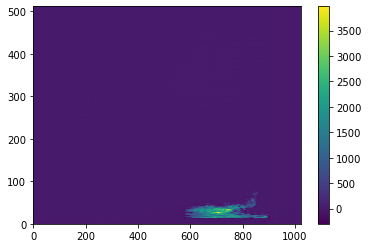

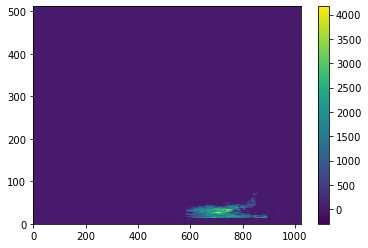

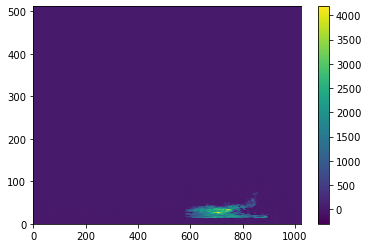

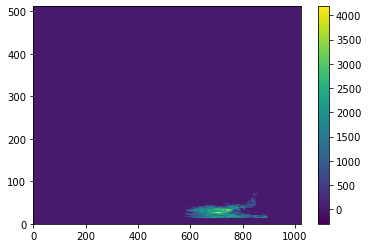

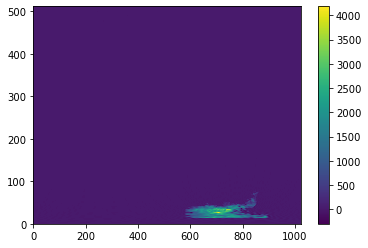

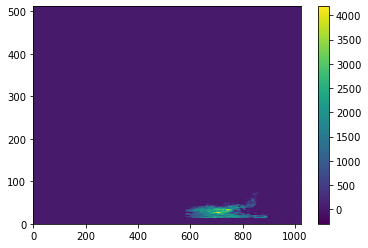

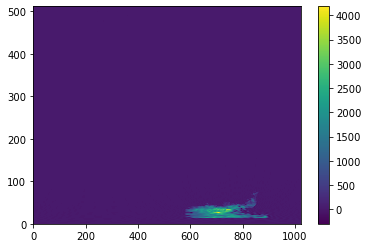

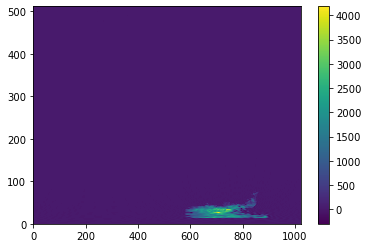

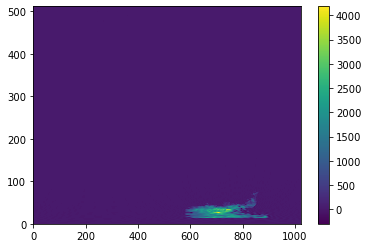

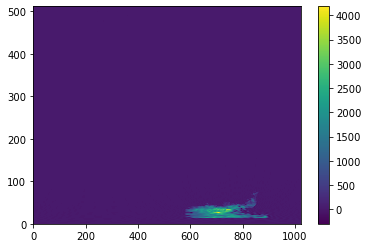

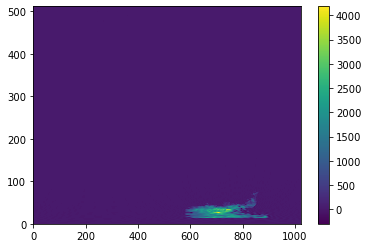

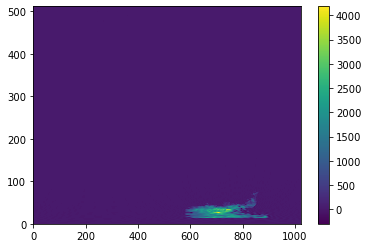

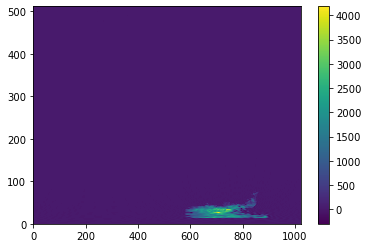

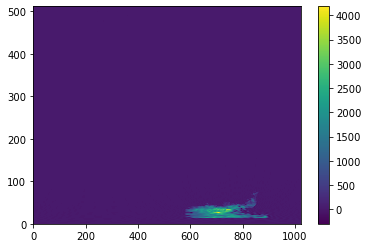

IndexError: index 14 is out of bounds for axis 0 with size 14

In [73]:
delS_ml.pcolor()

### Convergence criterion

In [72]:
if chi < epsilon:
  print('Converged after iteration', k, 'Chi was', chi)
else:
  print ('Did not yet converge.')
  print ('Finished iteration', k, '; Chi was', chi)

end_time = time.time()

print ("Time elapsed in k loop", end_time - start_time)
# calculate the scaling to normalize the fingerprint (it's normalized to be
# one on average, when averaged over the final ocean basin). 
# calculate change in sea level over final ocean basin
del_scaling = (delSL + del_ice_corrected) * oc_j
# get the average of that when spreading the water over the whole globe
sca = sh.grdtospec(del_scaling, norm='unity')
# get the average of that when spreading the water only over the oceans.
scaling_fact = sca[0] / ocj_ml[0]

Converged after iteration 14 Chi was 3.395161924952269e-11
Time elapsed in k loop 8.817554950714111


NameError: name 'del_ice_corrected' is not defined

## Plot Result